# Demand map generation

This notebook explain that what demand map is generated and how it looks.

In [1]:
import numpy as np
import deepsource as ds

import matplotlib.pylab as plt
from matplotlib import gridspec
from matplotlib.colors import LogNorm
%matplotlib inline

## Coefficient map $(C)$

Demand map is generated using actual image and a coefficient map produced according to true point source catalog.<br>
$D=(C+b_n)\times I^\alpha$<br>
which $D$ is demand map, $C$ is coefficient map and $I$ is image. Assume that we have a perfect (without any instrumental effects) image of sky which includes one point source. We can use a sequence of of kernels (beam function) and make the point source spreaded. In the following we used a sequence of two kernels (horn shape and gaussian) on the assumed point source.

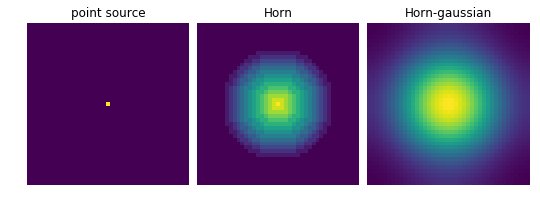

In [2]:
def kernel1(cat):
    return ds.horn_kernel(cat,radius=15,step_height=2)
def kernel2(cat):
    return ds.gaussian_kernel(cat,sigma=10)

image = np.zeros((41,41))
image[20,20] = 1

d_horn = ds.horn_kernel(image,radius=15,step_height=2)
d_horn_gauss = ds.gaussian_kernel(d_horn,sigma=7)

gs = gridspec.GridSpec(1, 3)
plt.figure(figsize=(9,3)) 

ax = plt.subplot(gs[0, 0])
ax.imshow(image)
ax.set_title('point source')
plt.axis('off');

ax = plt.subplot(gs[0, 1])
ax.imshow(d_horn)
ax.set_title('Horn')
plt.axis('off');

ax = plt.subplot(gs[0, 2])
ax.imshow(d_horn_gauss)
ax.set_title('Horn-gaussian')
plt.axis('off');

plt.subplots_adjust(wspace=0.05)

Now we can to same procedure on a larger image includes more point sources.

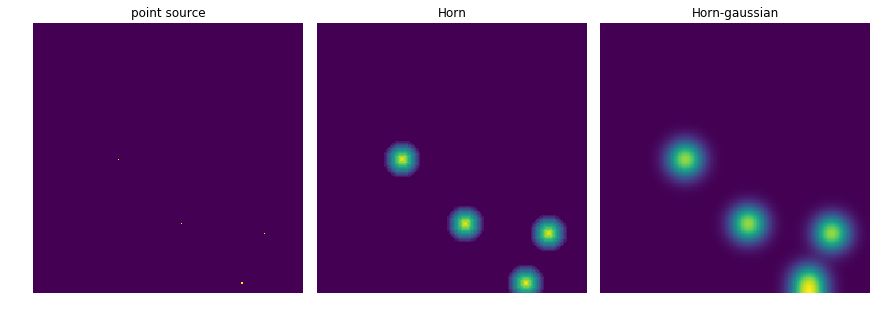

In [3]:
ps_list = np.random.randint(0,200,(4,2))
d_example = np.zeros((201,201))
for i,j in ps_list:
    d_example[i,j] = 1

d_horn = ds.horn_kernel(d_example,radius=15,step_height=2)
d_horn_gauss = ds.gaussian_kernel(d_horn,sigma=7)

gs = gridspec.GridSpec(1, 3)
plt.figure(figsize=(15,7)) 

ax = plt.subplot(gs[0, 0])
ax.imshow(d_example)
ax.set_title('point source')
plt.axis('off');

ax = plt.subplot(gs[0, 1])
ax.imshow(d_horn)
ax.set_title('Horn')
plt.axis('off');

ax = plt.subplot(gs[0, 2])
ax.imshow(d_horn_gauss)
ax.set_title('Horn-gaussian')
plt.axis('off');

plt.subplots_adjust(wspace=0.05)

## Demand map $(D)$

In real images, there are a lot of observational and instrumental effects and pollution (undesiered effects). Coefficient map uses true catalog to make a map to magnify point source regions. Effective length in kernels playes an important role in both training and accuracy. Too small length makes loss fucntion inefficient to train CNN and too large length makes point source detection inaccurate. In demand map equation, we adjust contribution of coefficient map and real image in demand map using $\alpha$ and $b_n$. $\alpha$ is responsible for the similarity of intensity of point sources between real image and demand map. If we chose $\alpha=0$, all of the point sources (ever sources buried in noise) will be appear in demand map by same shape. So this choice may make CNN confused because there are regions with no clue of point sources and we are forcing CNN to dig for them. In other hand if we chose $\alpha$ too large, CNN will not try to dig for faint sources! So $\alpha$ should be chosen by hyper-parameter estimation. Also $b_n$ controls background contribution. $b_n$ is important because it triggers CNN to learn about background. For example if we chose $b_n=0$ one local minima of loss fucntion is producing a zero output! To avoid that kind of dead learing, a small enough $b_n$ can help CNN to continue learing.

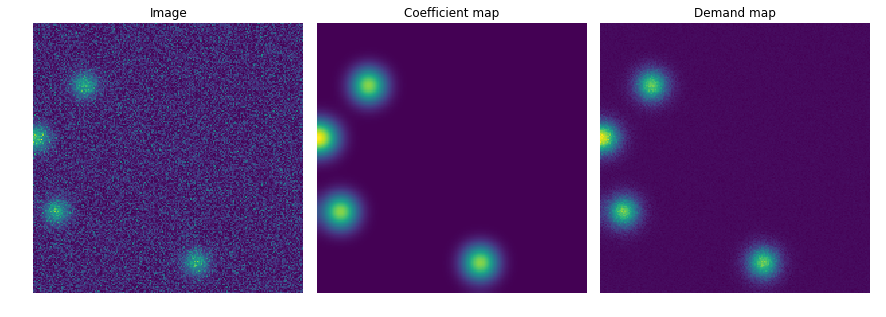

In [4]:
ps_list = np.random.randint(0,200,(4,2))
image = np.zeros((201,201))
for i,j in ps_list:
    image[i,j] = 1
    
image = ds.horn_kernel(image,radius=10,step_height=2)
image = ds.gaussian_kernel(image,sigma=5)
image += np.absolute(np.random.normal(0,0.2,(201,201)))

coeff = ds.cat2map(201,201,ps_list[:,1],ps_list[:,0])
coeff = ds.horn_kernel(coeff,radius=15,step_height=2)
coeff = ds.gaussian_kernel(coeff,sigma=7)

gs = gridspec.GridSpec(1, 3)
plt.figure(figsize=(15,7)) 

ax = plt.subplot(gs[0, 0])
ax.imshow(image)
ax.set_title('Image')
plt.axis('off');

ax = plt.subplot(gs[0, 1])
ax.imshow(coeff)
ax.set_title('Coefficient map')
plt.axis('off');

b_n = 0.05
alpha = 0.3
demand = (coeff+b_n)*image**alpha

ax = plt.subplot(gs[0, 2])
ax.imshow(demand)
ax.set_title('Demand map')
plt.axis('off');

plt.subplots_adjust(wspace=0.05)